In [81]:
import tensorflow as tf
import PIL
import os
import numpy as np
import cv2
import zipfile
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [82]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [83]:
import pathlib

img_height,img_width,batch_size=300,300,32
folder_dir = r"C:\Users\Pranav\OneDrive\Desktop\New folder"
  
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_dir,
  seed=130,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  folder_dir,
  seed=130,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width), 
  batch_size=batch_size)
class_names=train_ds.class_names

classes={0:"No Pothole",1:"Pothole"}


Found 883 files belonging to 2 classes.
Using 707 files for training.
Found 883 files belonging to 2 classes.
Using 176 files for validation.


In [14]:
import matplotlib.pyplot as plt


In [85]:
def generate_callback(path = "/content/drive/MyDrive/fabric_classification/", filename = "placeholder"):
    checkpoint = ModelCheckpoint(filepath = f'{path}{filename}.h5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

    return checkpoint

In [86]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
da = tf.keras.Sequential(
    [
        tf.keras.layers.RandomContrast(0.5),
        tf.keras.layers.RandomZoom(0.5),
        tf.keras.layers.RandomRotation(0.5)
    ]
)

In [90]:
num_classes = 2
resnet_model=Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_height,img_width,3),
    pooling='max',
    classes=num_classes
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.6))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(num_classes, activation='softmax'))

In [91]:
resnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 2)               

In [92]:
resnet_model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
checkpoint = generate_callback("/content/drive/MyDrive/fabric_classification/", "tomfile")
epochs=5
hist=resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks=[checkpoint])

Epoch 1/5
22/23 [===========================>..] - ETA: 0s - loss: 5.4744 - accuracy: 0.6136
Epoch 1: val_accuracy improved from -inf to 0.76705, saving model to /content/drive/MyDrive/fabric_classification\tomfile.h5
23/23 [==============================] - 13s 468ms/step - loss: 5.4552 - accuracy: 0.6139 - val_loss: 0.6364 - val_accuracy: 0.7670
Epoch 2/5
22/23 [===========================>..] - ETA: 0s - loss: 1.2805 - accuracy: 0.7614
Epoch 2: val_accuracy improved from 0.76705 to 0.93750, saving model to /content/drive/MyDrive/fabric_classification\tomfile.h5
23/23 [==============================] - 9s 416ms/step - loss: 1.2816 - accuracy: 0.7595 - val_loss: 0.2138 - val_accuracy: 0.9375
Epoch 3/5
22/23 [===========================>..] - ETA: 0s - loss: 0.6002 - accuracy: 0.7528
Epoch 3: val_accuracy did not improve from 0.93750
23/23 [==============================] - 9s 406ms/step - loss: 0.6026 - accuracy: 0.7511 - val_loss: 0.3341 - val_accuracy: 0.8864
Epoch 4/5
22/23 [======

In [114]:
converter=tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model=converter.convert()
open("linear2.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Pranav\AppData\Local\Temp\tmpf_4obydz\assets


INFO:tensorflow:Assets written to: C:\Users\Pranav\AppData\Local\Temp\tmpf_4obydz\assets


95050988

In [23]:
resnet_model.evaluate(val_ds)

21/21 [==============================] - 7s 303ms/step - loss: 0.4340 - accuracy: 0.8458


[0.43398186564445496, 0.8457943797111511]

In [94]:
prediction=resnet_model.predict(val_ds)
prediction

6/6 [==============================] - 3s 356ms/step


array([[2.73178634e-03, 9.97268200e-01],
       [5.04075200e-04, 9.99495864e-01],
       [6.86365440e-02, 9.31363463e-01],
       [9.98753428e-01, 1.24657981e-03],
       [6.66111588e-01, 3.33888471e-01],
       [4.99287963e-01, 5.00712037e-01],
       [8.59150946e-01, 1.40849069e-01],
       [8.50707069e-02, 9.14929330e-01],
       [5.34048828e-04, 9.99466002e-01],
       [8.03144872e-01, 1.96855158e-01],
       [3.49535793e-02, 9.65046406e-01],
       [5.47728121e-01, 4.52271909e-01],
       [4.67083395e-01, 5.32916605e-01],
       [7.85503805e-01, 2.14496225e-01],
       [6.04269793e-04, 9.99395728e-01],
       [2.86821067e-01, 7.13178933e-01],
       [5.34839667e-02, 9.46516037e-01],
       [2.90722307e-02, 9.70927775e-01],
       [1.13244485e-02, 9.88675594e-01],
       [3.12495958e-02, 9.68750358e-01],
       [4.48415130e-02, 9.55158532e-01],
       [9.50612843e-01, 4.93871421e-02],
       [1.22115258e-02, 9.87788498e-01],
       [4.86257859e-03, 9.95137393e-01],
       [9.342967

In [95]:
pred_val = tf.argmax(prediction, axis=1)
test_val = tf.concat([y for x, y in val_ds], axis=0)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_val, pred_val))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82        70
           1       0.85      0.94      0.90       106

    accuracy                           0.87       176
   macro avg       0.88      0.85      0.86       176
weighted avg       0.87      0.87      0.87       176



(-0.5, 299.5, 299.5, -0.5)

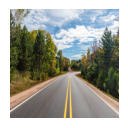

In [116]:
from PIL import Image
from PIL.Image import Resampling
img=Image.open(r"C:\Users\Pranav\OneDrive\Desktop\s1.jpg").resize((300,300))
Image.Resampling.LANCZOS
ax=plt.subplot(3, 3, 3)
plt.imshow(img)
plt.axis("off")

In [117]:
imarr=np.array(img)
imarr[np.newaxis, ...].shape

(1, 300, 300, 3)

In [118]:
pred=resnet_model.predict(imarr[np.newaxis, ...])
np.argmax(pred)

1/1 [==============================] - 0s 57ms/step


0

In [119]:
pred_label=np.argmax(pred)
classes={0:"Not Pothole",1:"Pothole"}
classes[pred_label]

'Not Pothole'